<a href="https://colab.research.google.com/github/Ritanjit/IITg_Internship_Assignments/blob/main/CIFAR_10_Dataset_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CIFAR-10 Classification Benchmark Study**

*This project implements multiple deep learning approaches to classify the CIFAR-10 dataset. The implementations include:*

*A. Custom CNN Classifier*

*B. AlexNet Classifier*

*C. Pre-trained ResNet Model*

*D. Pre-trained Inception Model*

*E. Custom Network Architecture*

---

# 1. Imports and Setup

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import time
import torchvision.models as models

In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration (automatically uses GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}\n")

Using device: cuda



# 2. Utility Functions

In [ ]:
# Image visualization function
def imshow(img, title=None):
    img = img / 2 + 0.5  # Reverse normalization
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

In [ ]:
def train_model(model, trainloader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        start_time = time.time()

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(trainloader):.4f} | Time: {epoch_time:.2f}s")
    return model

In [ ]:
def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy, all_preds, all_labels

In [ ]:
def visualize_predictions(model, testloader, classes, num_images=8):
    dataiter = iter(testloader)
    images, labels = next(dataiter)

    # Display images
    imshow(torchvision.utils.make_grid(images[:num_images]),
           title="Sample Predictions")

    # Get predictions
    images = images.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # Print labels
    print('Ground Truth:', ' '.join(f'{classes[labels[j]]:5s}' for j in range(num_images)))
    print('Predictions :', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(num_images)))

    # Visualize misclassifications
    visualize_misclassifications(model, testloader, classes, num_images)

In [ ]:
def visualize_misclassifications(model, testloader, classes, num_samples=8):
    misclass_imgs = []
    misclass_preds = []
    misclass_labels = []

    model.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Identify misclassifications
            mask = predicted != labels
            misclass_imgs.extend(images[mask].cpu())
            misclass_preds.extend(predicted[mask].cpu())
            misclass_labels.extend(labels[mask].cpu())

            if len(misclass_imgs) >= num_samples:
                break

    # Display misclassifications
    if misclass_imgs:
        print("\nMisclassified Examples:")
        imshow(torchvision.utils.make_grid(misclass_imgs[:num_samples]))
        print("Actual    :", ' '.join(f'{classes[l]:5s}' for l in misclass_labels[:num_samples]))
        print("Predicted :", ' '.join(f'{classes[p]:5s}' for p in misclass_preds[:num_samples]))
    else:
        print("No misclassifications found!")

# 3. Convolutional Neural Network (CNN) Classifier

In [ ]:
print("\n" + "="*50)
print("A. TRAINING CUSTOM CNN CLASSIFIER")
print("="*50)

# Data Preparation
transform_a = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset_a = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_a)
trainloader_a = torch.utils.data.DataLoader(trainset_a, batch_size=128,
                                          shuffle=True, num_workers=2)

testset_a = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_a)
testloader_a = torch.utils.data.DataLoader(testset_a, batch_size=128,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


A. TRAINING CUSTOM CNN CLASSIFIER


100%|██████████| 170M/170M [00:03<00:00, 42.8MB/s]


In [ ]:
# Model Architecture
class CIFAR10CNN(nn.Module):
    """Compact CNN optimized for CIFAR-10 classification."""
    def __init__(self):
        super(CIFAR10CNN, self).__init__()
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            # Conv Block 2
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.35),

            # Conv Block 3
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
# Initialize model
model_a = CIFAR10CNN().to(device)
criterion_a = nn.CrossEntropyLoss()
optimizer_a = optim.AdamW(model_a.parameters(), lr=0.001, weight_decay=1e-4)
scheduler_a = optim.lr_scheduler.ReduceLROnPlateau(optimizer_a, 'min', patience=3, factor=0.5)


Training Custom CNN:
Epoch 1/20 | Loss: 1.4233 | Time: 21.49s
Epoch 2/20 | Loss: 1.0276 | Time: 19.80s
Epoch 3/20 | Loss: 0.8703 | Time: 20.76s
Epoch 4/20 | Loss: 0.7957 | Time: 20.06s
Epoch 5/20 | Loss: 0.7360 | Time: 20.05s
Epoch 6/20 | Loss: 0.6989 | Time: 20.98s
Epoch 7/20 | Loss: 0.6542 | Time: 19.97s
Epoch 8/20 | Loss: 0.6243 | Time: 20.63s
Epoch 9/20 | Loss: 0.5976 | Time: 19.39s
Epoch 10/20 | Loss: 0.5676 | Time: 20.44s
Epoch 11/20 | Loss: 0.5495 | Time: 20.44s
Epoch 12/20 | Loss: 0.5252 | Time: 19.29s
Epoch 13/20 | Loss: 0.5119 | Time: 20.33s
Epoch 14/20 | Loss: 0.4926 | Time: 19.17s
Epoch 15/20 | Loss: 0.4788 | Time: 20.32s
Epoch 16/20 | Loss: 0.4635 | Time: 19.17s
Epoch 17/20 | Loss: 0.4562 | Time: 20.58s
Epoch 18/20 | Loss: 0.4417 | Time: 19.72s
Epoch 19/20 | Loss: 0.4313 | Time: 19.56s
Epoch 20/20 | Loss: 0.4194 | Time: 19.52s
Test Accuracy: 86.23%


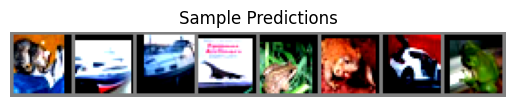

Ground Truth: cat   ship  ship  plane frog  frog  car   frog 
Predictions : cat   ship  car   plane frog  frog  car   frog 



Misclassified Examples:


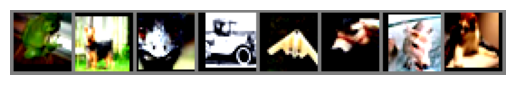

Actual    : frog  dog   bird  car   plane horse deer  cat  
Predicted : bird  deer  frog  truck horse cat   horse dog  


In [ ]:
# Training and evaluation
print("\nTraining Custom CNN:")
model_a = train_model(model_a, trainloader_a, criterion_a, optimizer_a, epochs=20)
accuracy_a, _, _ = evaluate_model(model_a, testloader_a)
visualize_predictions(model_a, testloader_a, classes)

# 4. ALEXNET CLASSIFIER

In [ ]:
print("\n" + "="*50)
print("B. TRAINING ALEXNET CLASSIFIER")
print("="*50)

# Data Preparation (AlexNet requires 224x224 input)
transform_b = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

trainset_b = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_b)
trainloader_b = torch.utils.data.DataLoader(trainset_b, batch_size=64,
                                          shuffle=True, num_workers=2)

testset_b = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_b)
testloader_b = torch.utils.data.DataLoader(testset_b, batch_size=64,
                                         shuffle=False, num_workers=2)


B. TRAINING ALEXNET CLASSIFIER


In [ ]:
# Model Initialization
model_b = models.alexnet(pretrained=False)
model_b.classifier[6] = nn.Linear(4096, 10)  # Modify last layer
model_b = model_b.to(device)

criterion_b = nn.CrossEntropyLoss()
optimizer_b = optim.SGD(model_b.parameters(), lr=0.005, momentum=0.9, weight_decay=5e-4)
scheduler_b = optim.lr_scheduler.StepLR(optimizer_b, step_size=7, gamma=0.1)


Training AlexNet:
Epoch 1/20 | Loss: 1.9587 | Time: 96.82s
Epoch 2/20 | Loss: 1.4164 | Time: 93.48s
Epoch 3/20 | Loss: 1.1379 | Time: 95.01s
Epoch 4/20 | Loss: 0.9176 | Time: 93.28s
Epoch 5/20 | Loss: 0.7870 | Time: 92.84s
Epoch 6/20 | Loss: 0.6807 | Time: 94.00s
Epoch 7/20 | Loss: 0.6024 | Time: 92.82s
Epoch 8/20 | Loss: 0.5359 | Time: 93.08s
Epoch 9/20 | Loss: 0.4756 | Time: 94.68s
Epoch 10/20 | Loss: 0.4121 | Time: 93.49s
Epoch 11/20 | Loss: 0.3661 | Time: 93.87s
Epoch 12/20 | Loss: 0.3241 | Time: 95.01s
Epoch 13/20 | Loss: 0.2836 | Time: 93.37s
Epoch 14/20 | Loss: 0.2564 | Time: 94.01s
Epoch 15/20 | Loss: 0.2204 | Time: 96.18s
Epoch 16/20 | Loss: 0.2020 | Time: 94.79s
Epoch 17/20 | Loss: 0.1861 | Time: 94.69s
Epoch 18/20 | Loss: 0.1640 | Time: 95.49s
Epoch 19/20 | Loss: 0.1545 | Time: 95.46s
Epoch 20/20 | Loss: 0.1327 | Time: 94.53s
Test Accuracy: 82.91%


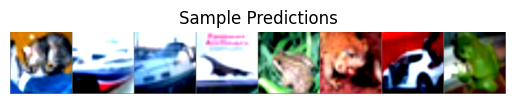

Ground Truth: cat   ship  ship  plane frog  frog  car   frog 
Predictions : cat   ship  plane plane frog  frog  car   frog 



Misclassified Examples:


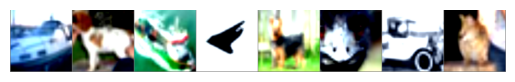

Actual    : ship  dog   ship  plane dog   bird  car   cat  
Predicted : plane deer  deer  bird  deer  cat   truck deer 


In [ ]:
# Training and evaluation
print("\nTraining AlexNet:")
model_b = train_model(model_b, trainloader_b, criterion_b, optimizer_b, epochs=20)
accuracy_b, _, _ = evaluate_model(model_b, testloader_b)
visualize_predictions(model_b, testloader_b, classes)

# 5. PRE-TRAINED RESNET

In [ ]:
print("\n" + "="*50)
print("C. FINE-TUNING PRE-TRAINED RESNET")
print("="*50)

# Data Preparation (ResNet requires 224x224 input)
transform_c = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

trainset_c = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_c)
trainloader_c = torch.utils.data.DataLoader(trainset_c, batch_size=64,
                                          shuffle=True, num_workers=2)

testset_c = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_c)
testloader_c = torch.utils.data.DataLoader(testset_c, batch_size=64,
                                         shuffle=False, num_workers=2)


C. FINE-TUNING PRE-TRAINED RESNET


In [ ]:
# Model Initialization (ResNet18)
model_c = models.resnet18(pretrained=True)

# Freeze all layers except final layer
for param in model_c.parameters():
    param.requires_grad = False

# Replace final layer
num_ftrs = model_c.fc.in_features
model_c.fc = nn.Linear(num_ftrs, 10)
model_c = model_c.to(device)

criterion_c = nn.CrossEntropyLoss()
optimizer_c = optim.Adam(model_c.fc.parameters(), lr=0.001)
scheduler_c = optim.lr_scheduler.CosineAnnealingLR(optimizer_c, T_max=10)


Fine-tuning ResNet:
Epoch 1/20 | Loss: 1.3257 | Time: 142.08s
Epoch 2/20 | Loss: 1.1519 | Time: 139.79s
Epoch 3/20 | Loss: 1.1290 | Time: 141.28s
Epoch 4/20 | Loss: 1.1115 | Time: 142.21s
Epoch 5/20 | Loss: 1.1196 | Time: 141.94s
Epoch 6/20 | Loss: 1.1007 | Time: 140.18s
Epoch 7/20 | Loss: 1.1022 | Time: 140.79s
Epoch 8/20 | Loss: 1.0916 | Time: 138.71s
Epoch 9/20 | Loss: 1.0875 | Time: 139.42s
Epoch 10/20 | Loss: 1.0920 | Time: 139.02s
Epoch 11/20 | Loss: 1.0963 | Time: 138.64s
Epoch 12/20 | Loss: 1.0877 | Time: 137.09s
Epoch 13/20 | Loss: 1.0868 | Time: 140.10s
Epoch 14/20 | Loss: 1.0884 | Time: 140.59s
Epoch 15/20 | Loss: 1.0906 | Time: 139.16s
Epoch 16/20 | Loss: 1.0848 | Time: 137.45s
Epoch 17/20 | Loss: 1.0840 | Time: 139.18s
Epoch 18/20 | Loss: 1.0854 | Time: 141.23s
Epoch 19/20 | Loss: 1.0877 | Time: 142.00s
Epoch 20/20 | Loss: 1.0898 | Time: 140.50s
Test Accuracy: 61.70%


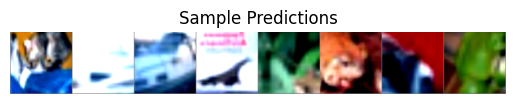

Ground Truth: cat   ship  ship  plane frog  frog  car   frog 
Predictions : cat   ship  ship  plane frog  frog  car   frog 



Misclassified Examples:


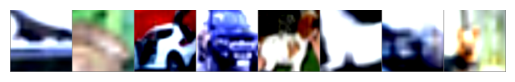

Actual    : plane frog  car   car   dog   horse ship  dog  
Predicted : ship  deer  truck truck cat   cat   plane cat  


In [ ]:
# Training and evaluation
print("\nFine-tuning ResNet:")
model_c = train_model(model_c, trainloader_c, criterion_c, optimizer_c, epochs=20)
accuracy_c, _, _ = evaluate_model(model_c, testloader_c)
visualize_predictions(model_c, testloader_c, classes)

# 6. PRE-TRAINED INCEPTION

In [ ]:
print("\n" + "="*50)
print("D. FINE-TUNING PRE-TRAINED INCEPTION V3")
print("="*50)

# Data Preparation (Inception requires 299x299 input)
transform_d = transforms.Compose([
    transforms.Resize(330),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

trainset_d = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_d)
trainloader_d = torch.utils.data.DataLoader(trainset_d, batch_size=32,
                                          shuffle=True, num_workers=2)

testset_d = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_d)
testloader_d = torch.utils.data.DataLoader(testset_d, batch_size=32,
                                         shuffle=False, num_workers=2)


D. FINE-TUNING PRE-TRAINED INCEPTION V3


In [ ]:
# Model Initialization with type-safe modifications
model_d = models.inception_v3(pretrained=True, aux_logits=True)

# Freeze base layers
for param in model_d.parameters():
    param.requires_grad = False

# 1. Main classifier replacement with type checking
if hasattr(model_d, 'fc') and isinstance(model_d.fc, nn.Linear):
    num_ftrs = model_d.fc.in_features
else:
    # Fallback: Known Inception v3 feature dimension
    num_ftrs = 2048

model_d.fc = nn.Linear(num_ftrs, 10)

# 2. Auxiliary classifier handling with existence check
if model_d.AuxLogits is not None:
    if hasattr(model_d.AuxLogits, 'fc') and isinstance(model_d.AuxLogits.fc, nn.Linear):
        num_aux_ftrs = model_d.AuxLogits.fc.in_features
    else:
        # Fallback: Known auxiliary classifier dimension
        num_aux_ftrs = 1024

    model_d.AuxLogits.fc = nn.Linear(num_aux_ftrs, 10)
else:
    # Handle missing auxiliary classifier
    print("Warning: AuxLogits is None! Proceeding without auxiliary classifier")

model_d = model_d.to(device)

criterion_d = nn.CrossEntropyLoss()
optimizer_d = optim.Adam(model_d.parameters(), lr=0.0005)


Fine-tuning Inception:
Epoch 1/20 | Loss: 1.5423
Epoch 2/20 | Loss: 1.2668
Epoch 3/20 | Loss: 1.2280
Epoch 4/20 | Loss: 1.2198
Epoch 5/20 | Loss: 1.2112
Epoch 6/20 | Loss: 1.2113
Epoch 7/20 | Loss: 1.2095
Epoch 8/20 | Loss: 1.2029
Epoch 9/20 | Loss: 1.1993
Epoch 10/20 | Loss: 1.1994
Epoch 11/20 | Loss: 1.1988
Epoch 12/20 | Loss: 1.1901
Epoch 13/20 | Loss: 1.1975
Epoch 14/20 | Loss: 1.1946
Epoch 15/20 | Loss: 1.1973
Epoch 16/20 | Loss: 1.1951
Epoch 17/20 | Loss: 1.2044
Epoch 18/20 | Loss: 1.1898
Epoch 19/20 | Loss: 1.1980
Epoch 20/20 | Loss: 1.1978
Test Accuracy: 74.89%


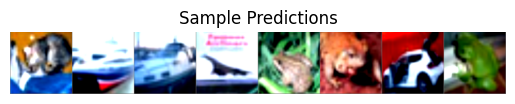

Ground Truth: cat   ship  ship  plane frog  frog  car   frog 
Predictions : dog   car   ship  plane frog  frog  car   frog 



Misclassified Examples:


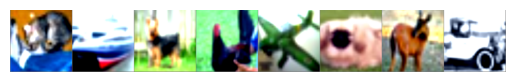

Actual    : cat   ship  dog   bird  plane dog   deer  car  
Predicted : dog   car   deer  horse bird  deer  horse truck


In [ ]:
# Training and evaluation
print("\nFine-tuning Inception:")
model_d.train()
for epoch in range(20):
    running_loss = 0.0
    for images, labels in trainloader_d:
        images, labels = images.to(device), labels.to(device)

        optimizer_d.zero_grad()

        # Handle different output formats based on auxiliary classifier
        if model_d.AuxLogits is not None:
            outputs, aux_outputs = model_d(images)
            loss1 = criterion_d(outputs, labels)
            loss2 = criterion_d(aux_outputs, labels)
            loss = loss1 + 0.4 * loss2  # Weighted loss
        else:
            outputs = model_d(images)
            loss = criterion_d(outputs, labels)

        loss.backward()
        optimizer_d.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/20 | Loss: {running_loss/len(trainloader_d):.4f}")

accuracy_d, _, _ = evaluate_model(model_d, testloader_d)
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')
visualize_predictions(model_d, testloader_d, classes)

# 7. CUSTOM ARCHITECTURE

In [ ]:
print("\n" + "="*50)
print("E. CUSTOM NEURAL NETWORK ARCHITECTURE")
print("="*50)

# Data Preparation
transform_e = transforms.Compose([
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset_e = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_e)
trainloader_e = torch.utils.data.DataLoader(trainset_e, batch_size=128,
                                          shuffle=True, num_workers=2)

testset_e = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_e)
testloader_e = torch.utils.data.DataLoader(testset_e, batch_size=128,
                                         shuffle=False, num_workers=2)


E. CUSTOM NEURAL NETWORK ARCHITECTURE


In [ ]:
# Custom Architecture
class CIFAR10Net(nn.Module):
    """
    Custom architecture with residual connections and depthwise separable convolutions.
    Features:
    - Residual blocks for improved gradient flow
    - Depthwise separable convolutions for efficiency
    - Skip connections for feature reuse
    """
    def __init__(self):
        super(CIFAR10Net, self).__init__()

        # Initial convolution
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # Residual Block 1
        self.res1 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64)
        )

        # Depthwise Separable Block
        self.depthwise = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1, groups=64),
            nn.Conv2d(64, 128, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Residual Block 2
        self.res2 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128)
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv1(x)

        # Residual connection 1
        residual = x
        x = self.res1(x)
        x += residual
        x = nn.ReLU()(x)

        x = self.depthwise(x)

        # Residual connection 2
        residual = x
        x = self.res2(x)
        x += residual
        x = nn.ReLU()(x)

        return self.classifier(x)

In [ ]:
# Initialize model
model_e = CIFAR10Net().to(device)
criterion_e = nn.CrossEntropyLoss()
optimizer_e = optim.RMSprop(model_e.parameters(), lr=0.001, weight_decay=1e-4)
scheduler_e = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_e, T_0=10)


Training Custom Architecture:
Epoch 1/20 | Loss: 1.6653 | Time: 22.33s
Epoch 2/20 | Loss: 1.3199 | Time: 22.08s
Epoch 3/20 | Loss: 1.1692 | Time: 21.74s
Epoch 4/20 | Loss: 1.0687 | Time: 21.95s
Epoch 5/20 | Loss: 1.0043 | Time: 22.05s
Epoch 6/20 | Loss: 0.9499 | Time: 21.70s
Epoch 7/20 | Loss: 0.9090 | Time: 21.75s
Epoch 8/20 | Loss: 0.8700 | Time: 22.19s
Epoch 9/20 | Loss: 0.8353 | Time: 22.28s
Epoch 10/20 | Loss: 0.8050 | Time: 21.60s
Epoch 11/20 | Loss: 0.7757 | Time: 22.01s
Epoch 12/20 | Loss: 0.7406 | Time: 22.25s
Epoch 13/20 | Loss: 0.7237 | Time: 22.20s
Epoch 14/20 | Loss: 0.6973 | Time: 21.17s
Epoch 15/20 | Loss: 0.6721 | Time: 22.07s
Epoch 16/20 | Loss: 0.6503 | Time: 22.09s
Epoch 17/20 | Loss: 0.6338 | Time: 21.53s
Epoch 18/20 | Loss: 0.6141 | Time: 21.87s
Epoch 19/20 | Loss: 0.6015 | Time: 22.19s
Epoch 20/20 | Loss: 0.5899 | Time: 22.69s
Test Accuracy: 67.59%


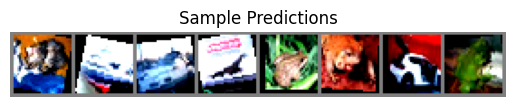

Ground Truth: cat   ship  ship  plane frog  frog  car   frog 
Predictions : cat   ship  ship  ship  frog  frog  car   bird 



Misclassified Examples:


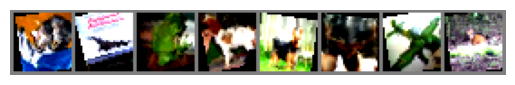

Actual    : cat   plane frog  dog   dog   deer  plane deer 
Predicted : ship  ship  bird  bird  deer  bird  bird  bird 


In [ ]:
# Training and evaluation
print("\nTraining Custom Architecture:")
model_e = train_model(model_e, trainloader_e, criterion_e, optimizer_e, epochs=20)
accuracy_e, _, _ = evaluate_model(model_e, testloader_e)
visualize_predictions(model_e, testloader_e, classes)

# 8. PERFORMANCE COMPARISON

In [ ]:
print("\n" + "="*50)
print("MODEL PERFORMANCE COMPARISON")
print("="*50)

# Create comparison table
print("\nModel Comparison:")
print(f"{'Model':<20} | {'Accuracy (%)':>12}")
print("-" * 35)
print(f"{'CNN':<20} | {accuracy_a:>12.2f}")
print(f"{'AlexNet':<20} | {accuracy_b:>12.2f}")
print(f"{'ResNet':<20} | {accuracy_c:>12.2f}")
print(f"{'Inception':<20} | {accuracy_d:>12.2f}")
print(f"{'Custom Architecture':<20} | {accuracy_e:>12.2f}")
print("-" * 35)


MODEL PERFORMANCE COMPARISON

Model Comparison:
Model                | Accuracy (%)
-----------------------------------
CNN                  |        86.23
AlexNet              |        82.91
ResNet               |        61.70
Inception            |        74.89
Custom Architecture  |        67.59
-----------------------------------


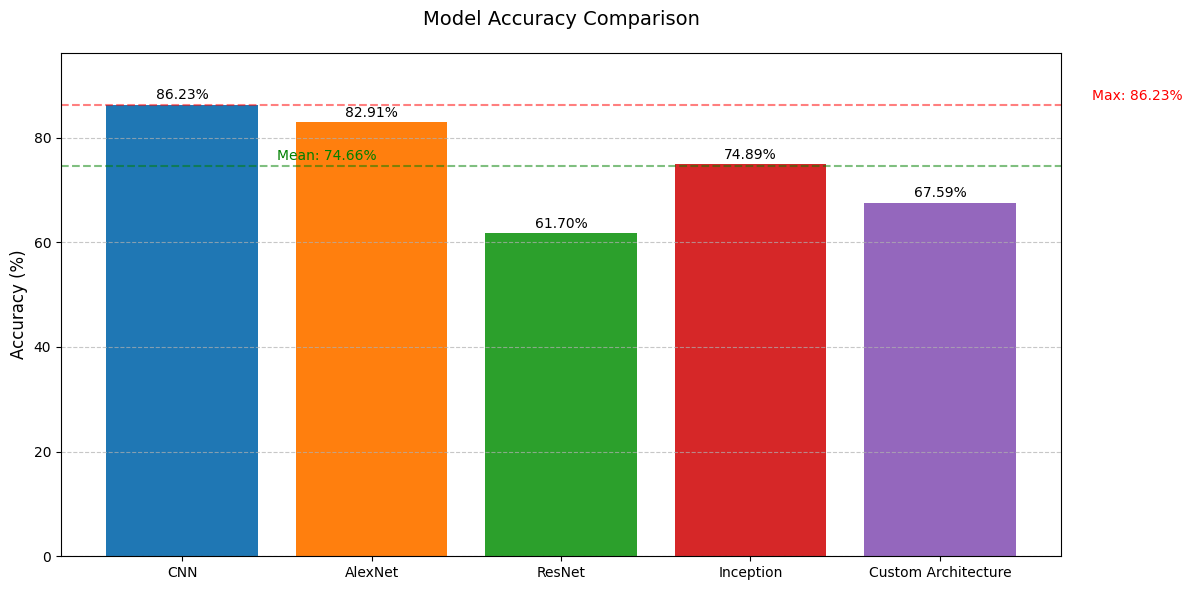

In [ ]:
# Visualization - Bar chart
models = ['CNN', 'AlexNet', 'ResNet', 'Inception', 'Custom Architecture']
accuracies = [accuracy_a, accuracy_b, accuracy_c, accuracy_d, accuracy_e]

plt.figure(figsize=(12, 6))
bars = plt.bar(models, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])

# alue labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.2f}%', ha='center', va='bottom')

plt.title('Model Accuracy Comparison', fontsize=14, pad=20)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.ylim(0, max(accuracies) + 10)  # Add headroom for labels
plt.grid(axis='y', linestyle='--', alpha=0.7)

# horizontal line at maximum accuracy
max_acc = max(accuracies)
plt.axhline(y=max_acc, color='r', linestyle='--', alpha=0.5)
plt.text(len(models)-0.2, max_acc+1, f'Max: {max_acc:.2f}%', color='r')

# performance insights
mean_acc = sum(accuracies)/len(accuracies)
plt.axhline(y=mean_acc, color='g', linestyle='--', alpha=0.5)
plt.text(0.5, mean_acc+1, f'Mean: {mean_acc:.2f}%', color='g')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300)
plt.show()

In [ ]:
# Save results summary
with open("results_summary.txt", "w") as f:
    f.write("CIFAR-10 Classification Results\n")
    f.write("=" * 35 + "\n")
    f.write(f"{'Model':<20} | {'Accuracy (%)':>12}\n")
    f.write("-" * 35 + "\n")
    f.write(f"{'Custom CNN':<20} | {accuracy_a:>12.2f}\n")
    f.write(f"{'AlexNet':<20} | {accuracy_b:>12.2f}\n")
    f.write(f"{'ResNet':<20} | {accuracy_c:>12.2f}\n")
    f.write(f"{'Inception':<20} | {accuracy_d:>12.2f}\n")
    f.write(f"{'Custom Architecture':<20} | {accuracy_e:>12.2f}\n")
    f.write("=" * 35 + "\n")
    f.write(f"Timestamp: {time.ctime()}\n")
    f.write(f"Device used: {device}\n")

print("\nResults saved to 'results_summary.txt'")


Results saved to 'results_summary.txt'
